In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
import statsmodels.formula.api as smf

In [2]:
restaurant_dataframe = pd.read_csv('raw_data/nyc_restaurant_inspection_results.csv')
rodent_dataframe = pd.read_csv('raw_data/rodent_inspection.csv')

In [3]:
restaurant_dataframe.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA'],
      dtype='object')

In [3]:
# get all restaurants that were inspected in 2021
restaurant_df = restaurant_dataframe.where(restaurant_dataframe['INSPECTION DATE'].str.contains(
    '2021', na=False) & (10001 <= restaurant_dataframe['ZIPCODE']) & (restaurant_dataframe['ZIPCODE'] <= 11697))
# removes rows with na score
restaurant_df = restaurant_df.dropna(how='any', subset=['SCORE'])


In [63]:
# restaurant_df.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA'],
      dtype='object')

In [29]:
# Check if there are any restauratns that don't have a score. There aren't any (see output)
restaurant_df['SCORE'].isna().sum()

0

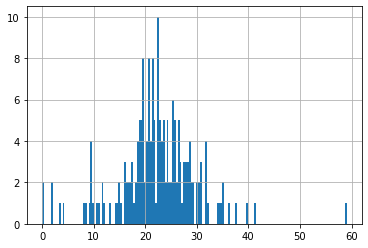

In [30]:
# see the distribution of the average restaurant scores grouped by zipcode where each column is a zipcode. It looks normal enough
restaurant_df.groupby('ZIPCODE')['SCORE'].mean().hist(bins=164)

In [24]:
rodent_dataframe.columns

Index(['INSPECTION_TYPE', 'JOB_TICKET_OR_WORK_ORDER_ID', 'JOB_ID',
       'JOB_PROGRESS', 'BBL', 'BORO_CODE', 'BLOCK', 'LOT', 'HOUSE_NUMBER',
       'STREET_NAME', 'ZIP_CODE', 'X_COORD', 'Y_COORD', 'LATITUDE',
       'LONGITUDE', 'BOROUGH', 'INSPECTION_DATE', 'RESULT', 'APPROVED_DATE',
       'LOCATION'],
      dtype='object')

In [4]:
# all reported rodent sightings in 2021, even if the inspection did not result in "Rat Activity"
rodent_df_all = rodent_dataframe[rodent_dataframe['INSPECTION_DATE'].str.contains('2021', na=False)]
# all reported rodent sightings in 2021 where the inspection resulted in "Rat Activity"
rodent_df_activity = rodent_dataframe[(rodent_dataframe['INSPECTION_DATE'].str.contains('2021', na=False)) & (rodent_dataframe['RESULT']=='Rat Activity')]

## Get descriptive statistics

In [32]:
restuarant_descriptive_stats = restaurant_df.groupby('ZIPCODE')['SCORE'].mean().describe()
rodent_all_descriptive_stats = rodent_df_all.groupby('ZIP_CODE')['JOB_TICKET_OR_WORK_ORDER_ID'].count().describe()
rodent_activity_descriptive_stats = rodent_df_activity.groupby('ZIP_CODE')['JOB_TICKET_OR_WORK_ORDER_ID'].count().describe()

### How many zipcodes don't overlap from each

In [33]:
extra_rodent_activity = set(rodent_df_activity.ZIP_CODE.unique()) - set(restaurant_df.ZIPCODE.unique())
extra_rodent_all = set(rodent_df_all.ZIP_CODE.unique()) - set(restaurant_df.ZIPCODE.unique())
extra_rest_act = set(restaurant_df.ZIPCODE.unique()) - set(rodent_df_activity.ZIP_CODE.unique())
extra_rest_all = set(restaurant_df.ZIPCODE.unique()) - set(rodent_df_all.ZIP_CODE.unique())

In [34]:
# Finding a unique key for the rows
rodent_df_all['JOB_TICKET_OR_WORK_ORDER_ID'].isna().sum()

0

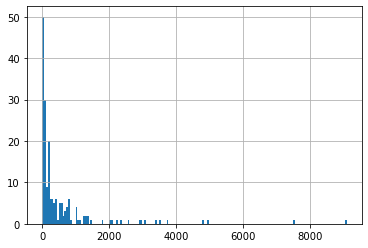

In [36]:
# rodent_df_all.groupby('ZIP_CODE')['JOB_TICKET_OR_WORK_ORDER_ID'].count().hist(bins=164)

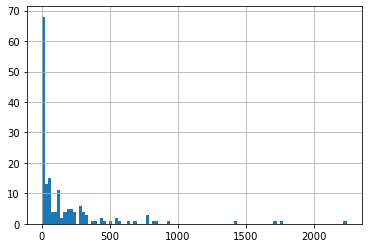

In [37]:
#rodent_df_activity.groupby('ZIP_CODE')['JOB_TICKET_OR_WORK_ORDER_ID'].count().hist(bins=100)

In [30]:
rodent_df_activity.groupby('ZIP_CODE')['JOB_TICKET_OR_WORK_ORDER_ID'].count().head()

ZIP_CODE
0.0          1
10001.0    116
10002.0    695
10003.0    332
10004.0     13
Name: JOB_TICKET_OR_WORK_ORDER_ID, dtype: int64

In [5]:
combined_data = pd.merge(
    left=rodent_df_activity.groupby('ZIP_CODE')['JOB_TICKET_OR_WORK_ORDER_ID'].count().reset_index(name='count'),
    right=restaurant_df.groupby('ZIPCODE')['SCORE'].mean().reset_index(name='avg_score'),
    how="inner",
    on=None,
    left_on='ZIP_CODE',
    right_on='ZIPCODE',
    left_index=False,
    right_index=False,
    sort=True,
    validate="1:1")

In [33]:
combined_data.head()

,ZIP_CODE,count,ZIPCODE,avg_score
0,10001.0,116,10001.0,14.866071
1,10002.0,695,10002.0,11.264706
2,10003.0,332,10003.0,14.000000
3,10004.0,13,10004.0,13.512821
4,10005.0,7,10005.0,18.285714


In [36]:
model = sm.OLS(combined_data.avg_score, combined_data['count'])
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              avg_score   R-squared (uncentered):                   0.192
Model:                            OLS   Adj. R-squared (uncentered):              0.187
Method:                 Least Squares   F-statistic:                              38.47
Date:                Tue, 05 Apr 2022   Prob (F-statistic):                    4.45e-09
Time:                        01:39:43   Log-Likelihood:                         -634.74
No. Observations:                 163   AIC:                                      1271.
Df Residuals:                     162   BIC:                                      1275.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Let's try to transform the rodent data to make it a little more normal

In [50]:
combined_data_copy = combined_data.copy()

In [35]:
combined_data_copy['log_count'] = np.log(combined_data_copy['count'])

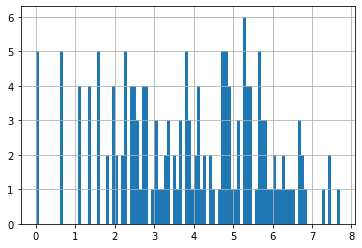

In [63]:
combined_data_copy.box_coxed.hist(bins=100)

In [36]:
model = sm.OLS(combined_data.avg_score, combined_data_copy.log_count)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              avg_score   R-squared (uncentered):                   0.787
Model:                            OLS   Adj. R-squared (uncentered):              0.785
Method:                 Least Squares   F-statistic:                              601.4
Date:                Mon, 11 Apr 2022   Prob (F-statistic):                    1.41e-56
Time:                        18:07:07   Log-Likelihood:                         -629.30
No. Observations:                 164   AIC:                                      1261.
Df Residuals:                     163   BIC:                                      1264.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------